# AAE 451 Preliminary Sizing

In [12]:
from typing import Callable

import numpy as np
import pandas as pd
import scipy.constants as consts
from scipy.optimize import minimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib import patheffects, patches

from IPython.display import display_latex

%matplotlib widget

In [20]:
# Define constants
RHO = 1.225  # kg / m^3

# Define requirements
v_to = 8. * consts.knot
r_turn = 200 * consts.foot
climb_rate = 400 * consts.foot / consts.minute
altitude = 200 * consts.foot

lap_straight = 600 * consts.foot
num_laps = 3
max_GTOM = 15 * consts.lb
max_wingspan = 5 * consts.foot

max_length = 60 * consts.inch

Takeoff sizing is... tricky. Our takeoff is going to have to involve a bit of a loft followed by acceleration to stall speed, because our takeoff speed would require insanely low wing loading to stall at that speed.

Let's start by estimating what a realistic stall speed would be as a function of aspect ratio. Assuming SLUF (steady, level, unaccelerating flight), $L=W=mg$, where $L$ is lift, $W$ is weight, $m$ is mass, and $g$ is standard gravitational acceleration. Using the lift coefficient equation, $L=C_L q S$ where the dynamic pressure $q \equiv \frac{1}{2}\rho u^2$, $C_L$ is the aircraft lift coefficient, $S$ is the wing area, $\rho$ is the air density, and $u$ is the flight speed. Aspect ratio is defined as $AR \equiv b^2 / S$, where $b$  is the wingspan. Solving for flight speed in $mg = C_L \frac{1}{2}\rho u^2 S$, we get $u = \sqrt{2mg/C_L S}$, or $u = \sqrt{2mg \cdot AR /C_L b^2}$. If we assume that $C_L = C_{L\text{,max}}$ in our stall constraint condition, we can find $u_\text{stall}$.

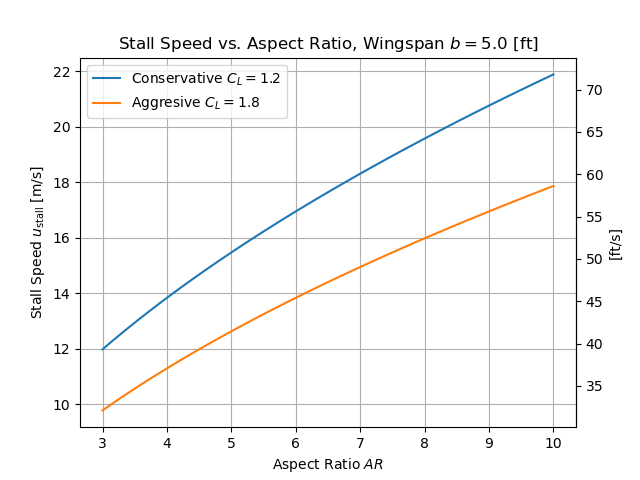

In [11]:
# Define conservative and aggressive values for CL_max
CL_max_cons = 1.2
CL_max_aggr = 1.8

# Define minimum and maximum values for aspect ratio
AR_min = 3
AR_max = 10

AR = np.linspace(AR_min, AR_max)

u_stall_cons = np.sqrt(2. * max_GTOM * consts.g * AR / (CL_max_cons * max_wingspan**2))
u_stall_aggr = np.sqrt(2. * max_GTOM * consts.g * AR / (CL_max_aggr * max_wingspan**2))

fig, ax = plt.subplots(1,1)

ax.plot(AR, u_stall_cons, label=f"Conservative $C_L = {CL_max_cons}$")
ax.plot(AR, u_stall_aggr, label=f"Aggresive $C_L = {CL_max_aggr}$")

ax.set_xlabel("Aspect Ratio $AR$")
ax.set_ylabel("Stall Speed $u_\\text{stall}$ [m/s]")

m2ft = lambda x: x / consts.foot
ft2m = lambda x: x * consts.foot

secax = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

secax.set_ylabel('[ft/s]')

ax.set_title(f"Stall Speed vs. Aspect Ratio, Wingspan $b = {max_wingspan / consts.foot}$ [ft]")

ax.legend()
ax.grid()

We now need to pick a reasonable value from this plot based on realistic aspect ratios and stall speeds. A realistic aspect ratio is probably in the range of 4 on the low end, up to 8 on the high end. These would correspond with mean geometric chords for the wings calculated as follows:

In [19]:
AR_lo = 4
AR_hi = 8

mgc_lo_AR = max_wingspan / AR_lo
mgc_hi_AR = max_wingspan / AR_hi

print(f"Mean Geom. Chord (Low AR)  = {mgc_lo_AR:.2f} m ; {mgc_lo_AR / consts.foot:.2f} ft ; {mgc_lo_AR / consts.inch:.2f} in")
print(f"Mean Geom. Chord (High AR) = {mgc_hi_AR:.2f} m ; {mgc_hi_AR / consts.foot:.2f} ft ; {mgc_hi_AR / consts.inch:.2f} in")

Mean Geom. Chord (Low AR)  = 0.38 m ; 1.25 ft ; 15.00 in
Mean Geom. Chord (High AR) = 0.19 m ; 0.62 ft ; 7.50 in


We can add an "eye test" to visualize what these look like.

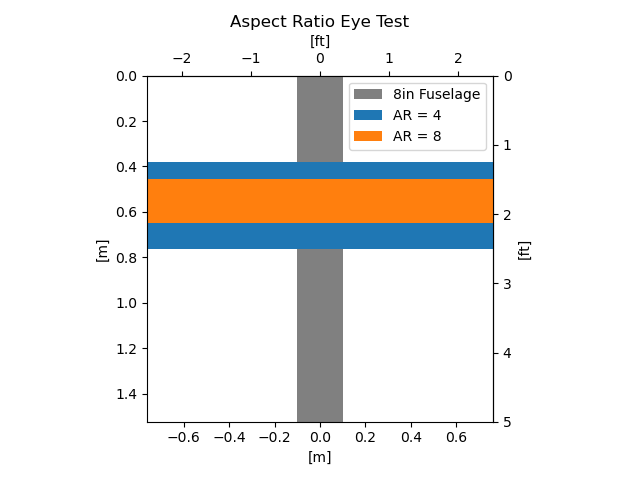

In [47]:
fig, ax = plt.subplots(1,1)

ax.set_xlim(-max_wingspan/2, max_wingspan/2)
ax.set_ylim(0, max_length)
ax.set_aspect('equal')
ax.invert_yaxis()

fuselage = patches.Rectangle((-4 * consts.inch, 0), 8 * consts.inch, max_length, facecolor='gray', label="8in Fuselage")
wing_lo_AR = patches.Rectangle((-max_wingspan / 2, max_length * 0.25), max_wingspan, mgc_lo_AR, facecolor='C0', label=f"AR = {AR_lo}")
wing_hi_AR = patches.Rectangle((-max_wingspan / 2, max_length * 0.3), max_wingspan, mgc_hi_AR, facecolor='C1', label=f"AR = {AR_hi}")

ax.add_patch(fuselage)
ax.add_patch(wing_lo_AR)
ax.add_patch(wing_hi_AR)

ax.legend(handles=[fuselage, wing_lo_AR, wing_hi_AR])

secaxx = ax.secondary_xaxis('top', functions=(m2ft, ft2m))
secaxy = ax.secondary_yaxis('right', functions=(m2ft, ft2m))

ax.set_xlabel('[m]')
ax.set_ylabel('[m]')
secaxx.set_xlabel('[ft]')
secaxy.set_ylabel('[ft]')

ax.set_title("Aspect Ratio Eye Test")
fig.tight_layout()

Whatever we pick for aspect ratio or stall speed, we will need a propultion system that can accelerate the vehicle to that speed from the launch speed before it hits the ground. We can solve this as a relatively simple dynamics problem.

Initially, we're going to assume the vehicle is launched at some initial flightpath angle at the launch speed, so it has some inital vertical and horiziontal velocity components. It will start from a certain vertical height, and begin falling due to gravity. Let's assume a starting height and a minimum acceptable height so we don't impact the ground. During this time, the vehicle accelerates under thrust from the launch speed. As the vehicle accelerates, it generates increasing lift proportional to its airspeed squared according to the lift equation. Simultaneously, drag increases on the vehicle as lift and velocity increase. A free body diagram describing the problem is shown below:

![Takeoff Dynamics](takeoff_dynamics.png)

The dynamical equations are as follows:

$$\begin{align*}
\dot{u} &= \frac{T}{m}\cos \alpha_{C_L\text{max}} - \frac{D}{m}\\
\dot{w} &= g - \frac{L}{m} - \frac{T}{m}\sin \alpha_{C_L\text{max}}\\
u(0) &= U_0 \cos \phi_0\\
w(0) &= -U_0 \sin \phi_0
\end{align*}$$

Where $u$ is horizontal velocity, $w$ is vertical velocity (positive down), $g$ is gravitational acceleration, $m$ is mass, $L$ is lift, $D$ is drag, $T$ is thrust, and $\alpha_{C_L\text{max}}$ is the angle of attack at stall.

In [ ]:
STARTING_ALT = 2.0 # meters
MIN_STALL_ALT = 1.0 # meters

FLIGHTPATH_ANGLE = np.deg2rad(0)